In [1]:
import os
import datetime
import string
import math
import tensorflow as tf
import sklearn.model_selection
import matplotlib.pyplot as plt

import keras_ocr

2024-09-30 08:45:00.170891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 08:45:00.309775: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Установка директории с данными
data_dir = 'text'

# Алфавит якутского языка
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

# Пути к файлам данных
wordlist_file = os.path.join(data_dir, 'sah.wordlist')
fonts_list_file = os.path.join(data_dir, 'okfonts_test.txt')
fonts_dir = os.path.join(data_dir, 'fonts')

In [3]:
# Загрузка списка слов из файла wordlist_file
with open(wordlist_file, 'r', encoding='utf-8') as f:
    word_list = [line.strip() for line in f if line.strip()]

# Создание генератора текста
def get_text_generator(words):
    while True:
        for word in words:
            yield word

text_generator = get_text_generator(word_list)
print('Первый сгенерированный текст:', next(text_generator))

Первый сгенерированный текст: аҕа


In [4]:
# Загрузка списка директорий шрифтов из файла fonts_list_file
with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]
    
font_paths = []

# Проходим по каждой директории и собираем файлы шрифтов
for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    # Рекурсивно ищем файлы шрифтов в директории font_dir_path
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

# Вывод количества найденных шрифтов
print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [5]:
# Разделение данных на тренировочные, валидационные и тестовые наборы
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

# Разделение списка слов
train_words, val_words, test_words = get_train_val_test_split(word_list)

# Разделение шрифтов
train_fonts, val_fonts, test_fonts = get_train_val_test_split(font_paths)

In [6]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for text/backgrounds.zip


In [7]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

# Разделение фоновых изображений
background_splits = get_train_val_test_split(backgrounds)

# Разделение шрифтов
font_splits = get_train_val_test_split(font_paths)

In [8]:
# Создание генераторов изображений
image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            char: current_fonts for char in recognizer_alphabet
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    ) for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

Первое сгенерированное валидационное изображение содержит текст: аҕал
аллар


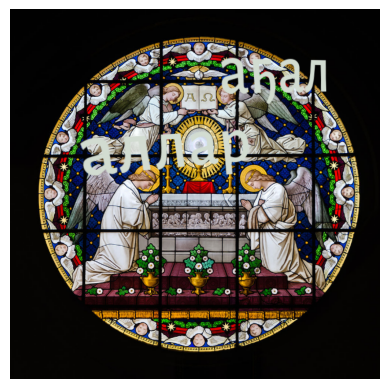

In [9]:
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('Первое сгенерированное валидационное изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
# Создание распознавателя
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights=None  # Обучение с нуля
)
recognizer.compile()

2024-09-30 08:45:03.337657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 08:45:05.889812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19458 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-09-30 08:45:05.890719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16858 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:24:00.0, compute capability: 8.6
2024-09-30 08:45:05.891394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [11]:
# Подготовка данных для обучения распознавателя
max_length = 15  # Максимальная длина строки

recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]


Это изображение содержит текст: аҕа


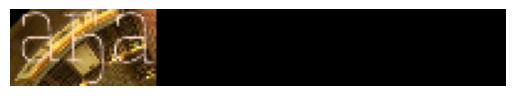

In [12]:
# Посмотрим, как выглядит первое сгенерированное изображение для распознавателя валидационной выборки
image, text = next(recognition_image_generators[1])
print('Это изображение содержит текст:', text)
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
# Создание генераторов батчей для распознавателя
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')

recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=recognition_batch_size,
        lowercase=True
    ) for image_generator in recognition_image_generators
]

In [14]:
# Поскольку генераторы бесконечны, вы можете задать фиксированное количество шагов на эпоху
train_steps = 100
val_steps = 20

# Обучение распознавателя
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=10,
    steps_per_epoch=train_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=val_steps,
    workers=0,
    batch_size=recognition_batch_size
)

Epoch 1/10


2024-09-30 08:45:14.292439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-09-30 08:45:15.965782: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 45s 358ms/step - loss: 15.1321 - val_loss: 13.0563
Epoch 2/10
100/100 [==============================] - 34s 344ms/step - loss: 10.6574 - val_loss: 11.4122
Epoch 3/10
100/100 [==============================] - 34s 344ms/step - loss: 11.4723 - val_loss: 11.5505
Epoch 4/10
100/100 [==============================] - 33s 334ms/step - loss: 10.8774 - val_loss: 11.7215
Epoch 5/10
100/100 [==============================] - 34s 338ms/step - loss: 10.4050 - val_loss: 11.0259
Epoch 6/10
100/100 [==============================] - 33s 334ms/step - loss: 9.6358 - val_loss: 11.8864
Epoch 7/10
100/100 [==============================] - 33s 328ms/step - loss: 10.2025 - val_loss: 8.9647
Epoch 8/10
100/100 [==============================] - 32s 318ms/step - loss: 12.0558 - val_loss: 13.0146
Epoch 9/10
100/100 [==============================] - 33s 326ms/step - loss: 11.4546 - val_loss: 10.7781
Epoch 10/10
100/100 [==============================] - 33s 332ms/ste